In [2]:
import pandas as pd
import re
import os
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df_o = pd.read_csv("logbook_assignment1.csv", dtype=str, encoding='utf-8', low_memory=False)
df = df_o.copy()
df_o.info()
df_o.head()
OUTPUT_PLOTS_DIR = "plots_numeric"
os.makedirs(OUTPUT_PLOTS_DIR, exist_ok=True)

# # --- Date columns ---
# df['date_fueled'] = pd.to_datetime(df['date_fueled'], format="%b %d %Y", errors="coerce")
# df['date_captured'] = pd.to_datetime(df['date_captured'], format="%b %d %Y", errors="coerce")

# # --- Helper function to clean numbers with commas/thousands separators ---
# def clean_numeric(series):
#     return (
#         series.astype(str)                      # ensure string
#         .str.replace(",", "", regex=False)      # remove commas
#         .str.strip()                            # strip whitespace
#     )

# # --- Odometer, gallons, miles ---
# df['odometer'] = pd.to_numeric(clean_numeric(df['odometer']), errors="coerce")
# df['gallons']  = pd.to_numeric(clean_numeric(df['gallons']), errors="coerce")
# df['miles']    = pd.to_numeric(clean_numeric(df['miles']), errors="coerce")

# # --- Costs: remove currency symbols & commas, then convert ---
# df['cost_per_gallon'] = (
#     df['cost_per_gallon']
#     .astype(str)
#     .str.replace(r"[^\d\.\,]", "", regex=True)   # keep only digits, dots, commas
#     .str.replace(",", "", regex=False)           # remove commas if present
# )
# df['cost_per_gallon'] = pd.to_numeric(df['cost_per_gallon'], errors="coerce")

# df['total_spent'] = (
#     df['total_spent']
#     .astype(str)
#     .str.replace(r"[^\d\.\,]", "", regex=True)
#     .str.replace(",", "", regex=False)
# )
# df['total_spent'] = pd.to_numeric(df['total_spent'], errors="coerce")

# # --- Other numeric fields ---
# df['mpg'] = pd.to_numeric(df['mpg'], errors="coerce")

# df['user_url'] = df['user_url'].astype(str) 

# df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174870 entries, 0 to 1174869
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   date_fueled      1125665 non-null  object
 1   date_captured    1174870 non-null  object
 2   odometer         1025716 non-null  object
 3   gallons          1100660 non-null  object
 4   cost_per_gallon  1094110 non-null  object
 5   total_spent      1100660 non-null  object
 6   mpg              1100660 non-null  object
 7   miles            146274 non-null   object
 8   user_url         1174870 non-null  object
dtypes: object(9)
memory usage: 80.7+ MB


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
0,"Cooling System, Heating System, Lights, Spark ...",Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...


# Date Fields
## Identify what percentage of date fueled entries that are not proper dates.[1]


In [3]:
#1.1 Cleaning:Date Fields
from dateutil.parser import parse
import warnings
from dateutil.parser._parser import UnknownTimezoneWarning

warnings.filterwarnings("ignore", category=UnknownTimezoneWarning)

#returns true if the entry is in a date format 
def validdate(s):
    if not isinstance(s, str) or not s.strip():
        return False
    try:
        parse(s, dayfirst=False,yearfirst=False,fuzzy=False)
        return True
    except Exception:
        return False

total = len(df)
invalid = (~df["date_fueled"].map(validdate)).sum()
invalidtotal= (invalid / total) * 100
print(f"Total dates: {total}")
print(f"Invalid dates: {invalid}")
print(f"Percentage of invalid dates: {invalidtotal:.3f}%")


Total dates: 1174870
Invalid dates: 135137
Percentage of invalid dates: 11.502%


## If date fueled is not entered correctly (or is not a date), and the date captured is a valid date, then fill in this value as a proxy. [1]


In [4]:
#1.2

fueled_list = df["date_fueled"].astype(str).tolist() #convert the 'date_fueled' column to a list of strings
captured_list = df["date_captured"].astype(str).tolist()
#keeps track of how many rows we fix
replaced_count = 0

for i in range(len(fueled_list)):
    if not validdate(fueled_list[i]):    #check if current fueled val is invalid
        if validdate(captured_list[i]):      #if fueled is invalid, check if captured is valid
            fueled_list[i] = captured_list[i]    #If captured is valid, replace fueled with captured/replace with proxy 
            replaced_count += 1 #increase the counter since we fixed one row
#update the DataFrame with the fixed fueled_lis
df["date_fueled"] = fueled_list

print(f"Rows filled from date_captured: {replaced_count}") #replacements made
print("valid fueled:", df["date_fueled"].map(validdate).sum()) #entries in the final date_fueled column are valid
print("valid captured:", df["date_captured"].map(validdate).sum())#entries in the date_captured column are valid
df.head()

Rows filled from date_captured: 135137
valid fueled: 1174870
valid captured: 1174870


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
0,Apr 7 2022,Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...


##  Convert the column to a date format, setting any invalid date fueled entries to NaT. [2]

In [5]:
#1.3

df["date_fueled_dt"] = pd.to_datetime(df["date_fueled"], errors="coerce", dayfirst=False)

#count invalids (NaT)
total = len(df)
nat_count = df["date_fueled_dt"].isna().sum()
print(f"entries converted to NaT: {nat_count} ({nat_count/total:.2%})")
df.head()

entries converted to NaT: 2073 (0.18%)


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt
0,Apr 7 2022,Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...,2022-02-15


In [6]:

# #remove later
# mask_validator_ok = df["date_fueled"].map(validdate)
# mask_pandas_nat   = df["date_fueled_dt"].isna()
# off_by_pandas = df.loc[mask_validator_ok & mask_pandas_nat, "date_fueled"].head(20)
# print("Validator OK but pandas NaT (samples):")
# print(off_by_pandas.to_list())

# print(df.loc[mask_validator_ok & mask_pandas_nat, "_date_fueled_raw"].head(20).to_list())


# print({
#     "validator_invalid": int((~mask_validator_ok).sum()),
#     "pandas_NaT": int(mask_pandas_nat.sum()),
#     "validator_ok_but_pandas_NaT": int((mask_validator_ok & mask_pandas_nat).sum())
# })


## Remove dates that are in the future, or dates that are earlier than 2005.[1]

In [7]:
#1.4
lower = pd.Timestamp("2005-01-01")
upper= pd.Timestamp.today().normalize()  #today's date

#True if inside the valid range)
mask = df["date_fueled_dt"].between(lower, upper, inclusive="both")

#filter the dataframe
before = len(df)
df = df[mask].copy()
after = len(df)

#many were dropped
print(f"Removed rows outside [{lower.date()} .. {upper.date()}]: {before - after}")
print(f"Rows remaining: {after}")




Removed rows outside [2005-01-01 .. 2025-09-06]: 2643
Rows remaining: 1172227


## Plot the distribution of fueling dates and comment on the results. [2]

Date range (after cleaning): 2005–2025
Peak year: 2021  (count = 340217)
Share of records in the last 5 years: 45.1%
Most common month number: 3 (1=Jan, 12=Dec)


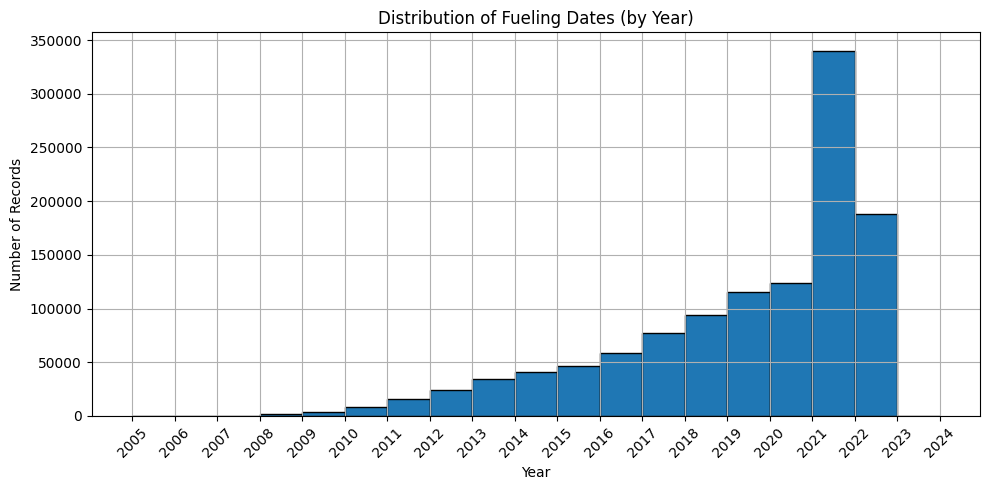

In [8]:
#1.5

#Make sure we have a datetime column
DATE_COL = "date fueled" if "date fueled" in df.columns else "date_fueled"
if "date_fueled_dt" not in df.columns:
    df["date_fueled_dt"] = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=False)

#keep only valid datetimes
dates = df["date_fueled_dt"].dropna()

years = dates.dt.year
months = dates.dt.month

year_counts = years.value_counts().sort_index()
month_counts = months.value_counts().sort_index()

start_year = int(years.min()) if not years.empty else None
end_year   = int(years.max()) if not years.empty else None

top_year = int(year_counts.idxmax()) if not year_counts.empty else None
top_year_n = int(year_counts.max()) if not year_counts.empty else 0

#last 5 yrs
if not years.empty:
    last5_mask = years >= (years.max() - 4)
    share_last5 = last5_mask.mean() * 100
else:
    share_last5 = 0.0

peak_month = int(month_counts.idxmax()) if not month_counts.empty else None
print(f"Date range (after cleaning): {start_year}–{end_year}")
print(f"Peak year: {top_year}  (count = {top_year_n})")
print(f"Share of records in the last 5 years: {share_last5:.1f}%")
print(f"Most common month number: {peak_month} (1=Jan, 12=Dec)")


if not years.empty:
    plt.figure(figsize=(10, 5))
    # use integer bins from min to max (+1 to close the last bin)
    bins = range(int(years.min()), int(years.max()))
    years.hist(bins=bins, edgecolor="black")
    plt.title("Distribution of Fueling Dates (by Year)")
    plt.xlabel("Year")
    plt.ylabel("Number of Records")
    plt.xticks(range(start_year, end_year), rotation=45)  # show all years
    plt.tight_layout()
    plt.show()

Comment on distribution of fueling dates: There seems to be an exponential growth in the number of fueling which suggests that there may be more cars/users added to the dataset that are contributing to the increasing number of fuelings every year. We also notice a large jump in fuelings in 2021 from 2020 which seems to be an outlier, this may point to some data inaccuracy since 2021 was during peak COVID 19 lockdown, so we would expect there to be a decrease in the number of fueling records.

# 1.2 Numeric Fields

In [9]:
#1.2 Helper Functions
def clean_numeric_series(s: pd.Series) -> pd.Series:
    """Remove common non-numeric characters and convert to float.

    Handles: commas (thousand separators), currency symbols, spaces,
    parentheses for negatives, and empty strings. Returns a float Series
    with NaN where conversion fails.
    """
    # Work on a string copy and guard for non-strings
    s2 = s.astype(str).str.strip()
    # Replace non-breaking spaces
    s2 = s2.str.replace(r" ", "", regex=True)
    # Remove currency symbols and thousands separators
    s2 = s2.str.replace(r"[,$£€¥]", "", regex=True)
    # Detect parentheses representing negatives
    has_paren = s2.str.startswith("(") & s2.str.endswith(")")
    # Remove parentheses and any stray characters except - . e digits
    s2 = s2.str.replace(r"[()]", "", regex=True)
    s2 = s2.str.replace(r"[^0-9.\-eE]", "", regex=True)
    # Treat blanks / "nan" strings as missing
    s2 = s2.replace({'': None, 'None': None, 'nan': None, 'NaN': None})
    out = pd.to_numeric(s2, errors='coerce')
    # Reapply negative sign where parentheses existed
    if has_paren.any():
        out.loc[has_paren] = -out.loc[has_paren].abs()
    return out


def percent_missing(df: pd.DataFrame, columns: list) -> pd.Series:
    return df[columns].isna().mean() * 100

## Identify what percentage of gallons, miles, and odometer entries are missing. [3]

In [10]:
# --- 1.2: Numeric cleaning (drop-in) ---

import numpy as np

# Use the robust cleaner you defined (it removes currency, text, parentheses, etc.)
NUMERIC_COLS = [c for c in ['miles','gallons','mpg','odometer'] if c in df.columns]
for col in NUMERIC_COLS:
    df[col] = clean_numeric_series(df[col])

# Basic plausibility filters: set impossible values to NaN before imputation
# Tune thresholds if your instructor provided different ranges.
if 'gallons' in df.columns:
    df.loc[(df['gallons'] <= 0) | (df['gallons'] > 80), 'gallons'] = np.nan  # >80 US gal is vanishingly rare
if 'mpg' in df.columns:
    df.loc[(df['mpg'] <= 0) | (df['mpg'] > 200), 'mpg'] = np.nan             # 200 mpg is not realistic for cars
if 'miles' in df.columns:
    df.loc[df['miles'] < 0, 'miles'] = np.nan                                # negative distance impossible

# (Optional) re-compute missingness after true numeric parsing
cols_for_missing = [c for c in ['gallons','miles','odometer'] if c in df.columns]
missing_pct_after = percent_missing(df, cols_for_missing)
print("Missing % AFTER numeric cleaning:")
print(missing_pct_after)


Missing % AFTER numeric cleaning:
gallons      6.422476
miles       87.599927
odometer    12.645503
dtype: float64


## The miles, gallons and mpg columns are interdependent. If one is missing, the other two can be used to calculate it. [3]

In [11]:
# --- 1.2.2: Algebraic imputation ---

derived_df = df.copy()   # working copy; leaves df intact

def plausible_miles(x):   return (x > 0) & (x < 2000)     # per fill-up (tweak if needed)
def plausible_gallons(x): return (x > 0.1) & (x < 50)     # typical car fill-up range
def plausible_mpg(x):     return (x > 3) & (x < 120)      # common road-vehicle range

def safe_div(num, den):
    """Elementwise division that returns NaN on divide-by-zero or non-finite."""
    out = num / den
    out[~np.isfinite(out)] = np.nan
    return out

# Iterate a few times until no more fills
for iteration in range(6):
    changed = False

    have = set(derived_df.columns)
    if not {'miles','gallons','mpg'}.issubset(have):
        break

    # Compute candidates
    mpg_calc     = safe_div(derived_df['miles'], derived_df['gallons'])
    miles_calc   = derived_df['mpg'] * derived_df['gallons']
    gallons_calc = safe_div(derived_df['miles'], derived_df['mpg'])

    # Fill mpg where missing and candidate is plausible
    m = (
        derived_df['mpg'].isna()
        & plausible_miles(derived_df['miles'])
        & plausible_gallons(derived_df['gallons'])
        & plausible_mpg(mpg_calc)
    )
    if m.any():
        derived_df.loc[m, 'mpg'] = mpg_calc[m]
        changed = True

    # Fill miles where missing and candidate is plausible
    m = (
        derived_df['miles'].isna()
        & plausible_mpg(derived_df['mpg'])
        & plausible_gallons(derived_df['gallons'])
        & plausible_miles(miles_calc)
    )
    if m.any():
        derived_df.loc[m, 'miles'] = miles_calc[m]
        changed = True

    # Fill gallons where missing and candidate is plausible
    m = (
        derived_df['gallons'].isna()
        & plausible_miles(derived_df['miles'])
        & plausible_mpg(derived_df['mpg'])
        & plausible_gallons(gallons_calc)
    )
    if m.any():
        derived_df.loc[m, 'gallons'] = gallons_calc[m]
        changed = True

    print(f"Iteration {iteration+1}: changed={changed}")
    if not changed:
        break

derived_df.head()


Iteration 1: changed=True
Iteration 2: changed=False


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt
0,Apr 7 2022,Apr 7 2022,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07
1,Nov 7 2012,Aug 30 2016,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07
2,Sep 22 2012,Sep 28 2012,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22
3,May 4 2019,May 4 2019,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,2022-02-15


## The values will be read in as objects (or strings) by Pandas. Convert these values to float (note the point above about commas in the value). [5]

In [12]:
# --- Sanity check & unit diagnostics ---

check_mask = (
    derived_df[['miles','gallons','mpg']].notna().all(axis=1)
    & plausible_miles(derived_df['miles'])
    & plausible_gallons(derived_df['gallons'])
    & plausible_mpg(derived_df['mpg'])
)

chk = derived_df.loc[check_mask, ['miles','gallons','mpg']].copy()
chk['expected_miles'] = chk['mpg'] * chk['gallons']

# Ignore tiny expected mileages (<5) to avoid exploding relative errors from rounding
chk = chk[chk['expected_miles'] >= 5]

# Relative error
chk['rel_err'] = (chk['miles'] - chk['expected_miles']).abs() / chk['expected_miles'].abs()

# Report
thr = 0.15  # 15% tolerance accommodates rounding and pump cut-offs; tighten later if you like
bad = chk[chk['rel_err'] > thr]
print(f"Sanity check: {len(chk) - len(bad)} / {len(chk)} "
      f"({(1 - len(bad)/max(len(chk),1)):.1%}) within {int(thr*100)}% tolerance.")
print(f"Median rel. err: {chk['rel_err'].median():.2%} | 95th pct: {chk['rel_err'].quantile(0.95):.2%}")

# --- Unit diagnostics ---
# If gallons were actually LITRES, expected_miles will be ~3.785x too large, so miles/expected ≈ 0.264.
# If miles were actually KILOMETRES, miles/expected ≈ 1.609.
# If BOTH (km & litres), miles/expected ≈ 1.609 / 3.785 ≈ 0.425 (or the inverse 6.09 depending on arrangement).
rat = chk['miles'] / chk['expected_miles']

def pct_between(a, lo, hi): 
    a = a.to_numpy()
    return (np.isfinite(a) & (a>=lo) & (a<=hi)).mean() * 100

print("Possible unit-mix fingerprints (share of checked rows):")
print(f"  ≈ litres-in-gallons (ratio ~0.264): {pct_between(rat, 0.24, 0.29):5.1f}%")
print(f"  ≈ kilometres-in-miles (ratio ~1.609): {pct_between(rat, 1.50, 1.70):5.1f}%")
print(f"  ≈ both km & litres (~0.425): {pct_between(rat, 0.39, 0.46):5.1f}%")
print(f"  ≈ UK gallon (4.546 L vs 3.785; ratio ~0.833 or ~1.2): "
      f"{pct_between(rat, 0.78, 0.88) + pct_between(rat, 1.15, 1.25):5.1f}% (combined)")
derived_df.head()
derived_df.info()

Sanity check: 955962 / 957092 (99.9%) within 15% tolerance.
Median rel. err: 0.00% | 95th pct: 0.13%
Possible unit-mix fingerprints (share of checked rows):
  ≈ litres-in-gallons (ratio ~0.264):   0.0%
  ≈ kilometres-in-miles (ratio ~1.609):   0.0%
  ≈ both km & litres (~0.425):   0.0%
  ≈ UK gallon (4.546 L vs 3.785; ratio ~0.833 or ~1.2):   0.0% (combined)
<class 'pandas.core.frame.DataFrame'>
Index: 1172227 entries, 0 to 1174869
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_fueled      1172227 non-null  object        
 1   date_captured    1172227 non-null  object        
 2   odometer         1023993 non-null  float64       
 3   gallons          1096941 non-null  float64       
 4   cost_per_gallon  1091571 non-null  object        
 5   total_spent      1098094 non-null  object        
 6   mpg              962196 non-null   float64       
 7   miles            957751 non-nul

##  Plot the distributions and comment on the distributions. [3]

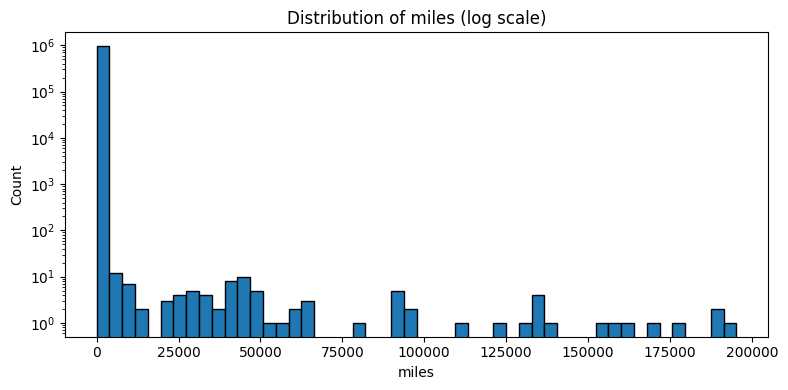

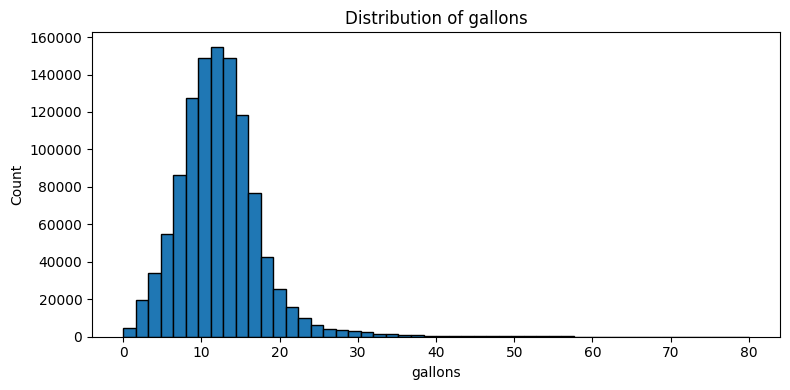

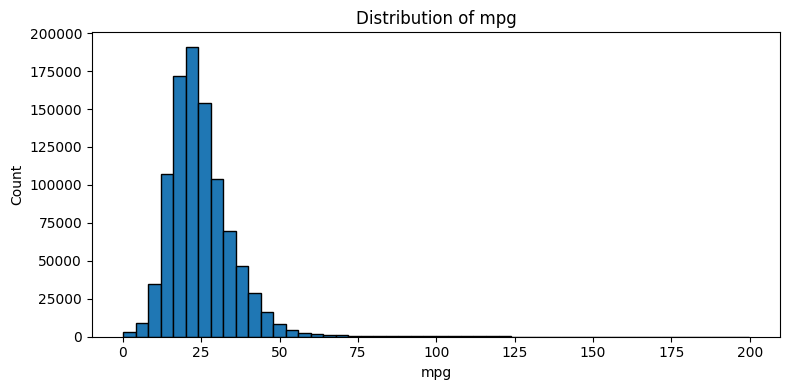

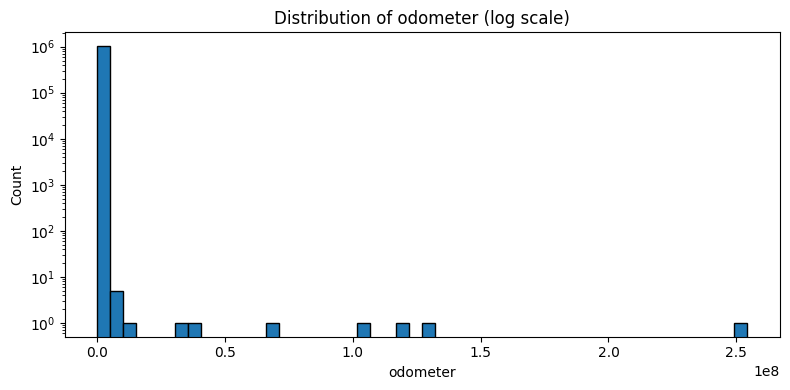

In [13]:
# 1.2.4 — Distribution plots for numeric columns
num_cols = [c for c in ['miles', 'gallons', 'mpg', 'odometer'] if c in derived_df.columns]

for col in num_cols:
    plt.figure(figsize=(8, 4))
    data = derived_df[col].dropna()

    # Use log scale if data is highly skewed
    if data.max() > 0 and data.median() > 0 and (data.max() / data.median()) > 50:
        plt.hist(data, bins=50, edgecolor="black", log=True)
        plt.yscale("log")
        plt.title(f"Distribution of {col} (log scale)")
    else:
        plt.hist(data, bins=50, edgecolor="black")
        plt.title(f"Distribution of {col}")

    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## Compute the statistical description of the columns: mean, standard deviation, max, min, most frequent, and quartiles. Do these results make sense? [3]

In [14]:
# 1.2.5 — Statistical summary
stats = derived_df[num_cols].describe().T
stats["most_frequent"] = [derived_df[c].mode().iloc[0] if not derived_df[c].mode().empty else None for c in num_cols]

print("Statistical summary of numeric columns:")
display(stats)

# Simple interpretation helper: flag suspicious values
for col in num_cols:
    col_stats = stats.loc[col]
    print(f"\nColumn: {col}")
    print(f"  Mean = {col_stats['mean']:.2f}, Std = {col_stats['std']:.2f}")
    print(f"  Min = {col_stats['min']}, Max = {col_stats['max']}")
    print(f"  Median (50%) = {col_stats['50%']:.2f}")
    print(f"  Most frequent = {col_stats['most_frequent']}")

    # Quick sanity checks
    if col == "mpg" and col_stats["max"] > 100:
        print(" Warning: MPG above 100 detected (likely bad entry).")
    if col == "odometer" and col_stats["min"] < 0:
        print(" Warning: Negative odometer readings detected.")


Statistical summary of numeric columns:


,count,mean,std,min,25%,50%,75%,max,most_frequent
miles,957751.0,302.894495,757.284939,0.100,219.4671,283.7408,354.654,195321.2,300.000
gallons,1096941.0,12.319848,5.440403,0.001,8.9920,11.9530,14.933,80.0,10.567
mpg,962196.0,25.156547,11.619624,0.100,18.2000,23.3000,29.800,199.7,21.000
odometer,1023993.0,104001.372196,340798.478033,0.000,45926.0000,91882.0000,146923.000,254362100.0,1.000



Column: miles
  Mean = 302.89, Std = 757.28
  Min = 0.1, Max = 195321.2
  Median (50%) = 283.74
  Most frequent = 300.0

Column: gallons
  Mean = 12.32, Std = 5.44
  Min = 0.001, Max = 80.0
  Median (50%) = 11.95
  Most frequent = 10.567

Column: mpg
  Mean = 25.16, Std = 11.62
  Min = 0.1, Max = 199.7
  Median (50%) = 23.30
  Most frequent = 21.0

Column: odometer
  Mean = 104001.37, Std = 340798.48
  Min = 0.0, Max = 254362100.0
  Median (50%) = 91882.00
  Most frequent = 1.0


In [15]:
# Commit imputed values back to main dataframe
df = derived_df.copy()
df.head()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt
0,Apr 7 2022,Apr 7 2022,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07
1,Nov 7 2012,Aug 30 2016,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07
2,Sep 22 2012,Sep 28 2012,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22
3,May 4 2019,May 4 2019,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,2022-02-15


#  Feature Engineering

## Create a new column with the currency. (Something to keep in mind is that the Swiss Franc has a period in the abbreviation). [2]


In [16]:
#2a.1

df["currency"] = df["cost_per_gallon"].astype("string").str.extract(r'^([^\d]+)') #gets everything up to the first number, then get currency
print(df[[ "currency"]].head(15)) # first 15 rows of the new currency column 
print(df["currency"].unique()) #all unique values found in the currency column

   currency
0      <NA>
1         $
2         £
3         £
4         $
5         $
6         $
7         $
8      <NA>
9         $
10      RON
11        $
12        $
13        $
14        €
<StringArray>
[  <NA>,    '$',    '£',  'RON',    '€',   'zł',  'AU$',    '₩',   'Ft',
  'NZ$',
 ...
   'Bs', 'NAf.',  'KZT',   'YR',  'MAD',  'CV$',  'IQD',  'CU$',  'KGS',
   'L$']
Length: 122, dtype: string


## Create a new column containing the float value of the total spend and the cost per gallon. (Swiss Franc comment as above). [2]

In [17]:
#2a.2
#gets rid of non-numeric characters (keep digits, dot, comma)
def to_float(s):
    if not isinstance(s, str):
        return None
    #remove currency symbols, keep digits, commas
    num = re.sub(r"[^\d.,]", "", s)
    #replace comma with nothing 
    num = num.replace(",", "")
    try:
        return float(num) if num else None
    except ValueError:
        return None
df["cost_per_gallon_float"] = df["cost_per_gallon"].astype("string").apply(to_float)
df["total_spent_float"]     = df["total_spent"].astype("string").apply(to_float)

print(df[["cost_per_gallon", "cost_per_gallon_float",
          "total_spent", "total_spent_float"]].head(10))

  cost_per_gallon  cost_per_gallon_float total_spent  total_spent_float
0             NaN                    NaN         NaN                NaN
1          $5.599                  5.599      $67.86              67.86
2           £5.45                  5.450      £43.53              43.53
3           £5.11                  5.110      £54.00              54.00
4          $3.029                  3.029      $35.29              35.29
5          $3.739                  3.739      $12.76              12.76
6          $4.639                  4.639      $41.96              41.96
7          $2.929                  2.929      $43.82              43.82
8             NaN                    NaN         NaN                NaN
9          $1.999                  1.999       $5.42               5.42


## Car make, model, year, User ID: use the url (the last value in the URL is the user ID) [4]

In [18]:
#2.3
parts = df["user_url"].str.split("/", expand=True)

df["make"]    = parts[3].astype("string")
df["model"]   = parts[4].astype("string")
df["year"]    = pd.to_numeric(parts[5], errors="coerce").astype("Int64")
df["user_id"] = parts[6].astype("string")  

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1172227 entries, 0 to 1174869
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   date_fueled            1172227 non-null  object        
 1   date_captured          1172227 non-null  object        
 2   odometer               1023993 non-null  float64       
 3   gallons                1096941 non-null  float64       
 4   cost_per_gallon        1091571 non-null  object        
 5   total_spent            1098094 non-null  object        
 6   mpg                    962196 non-null   float64       
 7   miles                  957751 non-null   float64       
 8   user_url               1172227 non-null  object        
 9   date_fueled_dt         1172227 non-null  datetime64[ns]
 10  currency               1091571 non-null  string        
 11  cost_per_gallon_float  1089547 non-null  float64       
 12  total_spent_float      1096017 no

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt,currency,cost_per_gallon_float,total_spent_float,make,model,year,user_id
0,Apr 7 2022,Apr 7 2022,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07,<NA>,NaN,NaN,suzuki,swift,2015,674857
1,Nov 7 2012,Aug 30 2016,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07,$,5.599,67.86,bmw,x3,2009,461150
2,Sep 22 2012,Sep 28 2012,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22,£,5.450,43.53,mercedes-benz,e300,1998,133501
3,May 4 2019,May 4 2019,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04,£,5.110,54.00,bmw,320d,2010,247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,2022-02-15,$,3.029,35.29,honda,passport,2019,1038865


The data is given in imperial units, and in SA, we use proper measurement standards.
## litres filled: use the gallons - consider whether to use UK or US gallons. [2]

In [24]:
# Step 1: convert gallons to litres (UK gallons)
df["litres_filled"] = df["gallons"] * 4.54609

# Step 2: convert miles to km
df["km_driven"] = df["miles"] * 1.60934

# Step 3: calculate litres per 100 km
df["litres_per_100km"] = (df["litres_filled"] / df["km_driven"]) * 100

df

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt,currency,cost_per_gallon_float,total_spent_float,make,model,year,user_id,litres_filled,km_driven,litres_per_100km
0,Apr 7 2022,Apr 7 2022,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07,<NA>,NaN,NaN,suzuki,swift,2015,674857,NaN,NaN,NaN
1,Nov 7 2012,Aug 30 2016,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07,$,5.599,67.86,bmw,x3,2009,461150,55.098611,616.364345,8.939292
2,Sep 22 2012,Sep 28 2012,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22,£,5.450,43.53,mercedes-benz,e300,1998,133501,36.327805,366.516724,9.911636
3,May 4 2019,May 4 2019,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04,£,5.110,54.00,bmw,320d,2010,247233,48.074902,796.478459,6.035932
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,2022-02-15,$,3.029,35.29,honda,passport,2019,1038865,52.966495,393.322696,13.466422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174865,Feb 19 2020,Feb 19 2020,118237.0,13.046,$1.999,$26.08,25.7,335.2822,https://www.somewebsite.com/volkswagen/beetle/...,2020-02-19,$,1.999,26.08,volkswagen,beetle,2005,388391,59.308290,539.583056,10.991503
1174866,Dec 6 2019,Dec 6 2019,141761.0,12.637,$2.449,$30.95,20.0,252.7400,https://www.somewebsite.com/toyota/avalon/2000...,2019-12-06,$,2.449,30.95,toyota,avalon,2000,432408,57.448939,406.744592,14.124082
1174867,Oct 4 2021,Oct 4 2021,65029.0,10.002,$3.449,$34.50,28.5,285.0570,https://www.somewebsite.com/fiat/500/2013/909694,2021-10-04,$,3.449,34.50,fiat,500,2013,909694,45.469992,458.753632,9.911636
1174868,Jul 26 2021,Jul 26 2021,15255.0,10.493,$3.539,$37.13,36.5,382.9945,https://www.somewebsite.com/mini/cooper/2019/9...,2021-07-26,$,3.539,37.13,mini,cooper,2019,952426,47.702122,616.368369,7.739223
